# Wait Time Analysis

In [1]:
# IMPORT FUNCTIONALITIES
import pandas as pd
import numpy as np
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

%load_ext nb_black

<IPython.core.display.Javascript object>

Below, the file containing the candidate properties is read in and the burst times are sorted into an array. This is specified for our file structure and burst fitting procedure, and will likely need to be changed. The endpoints for the histogram bins are also specified. <br>
We only need the MJDs for this analysis, but pandas is used so one can easily incorporate other burst properties like fluence or DM into the analysis.

In [2]:
# Read in data file
data = pd.read_csv("/home/elewis/FRB121102/all_bursts_bary.csv")
data = data[(data["fit_method"] == "mcmc")]  # excise bursts fit using curvefit
print(str(len(data)) + " good MCMC bursts")

data_flu = data[(data["use_fluence"] == True)]
print(str(len(data_flu)) + " good MCMC/fluence bursts")

# Bursts for which there are good fluence measurements, for fluence analysis
mjd_flu = data_flu["$\mu_t$ (ms)"]
mjd_flu = mjd_flu.sort_values()
fluence_flu = data_flu["$S$ (Jy ms)"]

datadict_flu = {"MJD": mjd_flu, "fluence": fluence_flu}
dataframe_flu = pd.concat(datadict_flu, axis=1)
bursts_by_fluence = dataframe_flu.sort_values(by="fluence")

# Break into individual MJD array
mjd = data["$\mu_t$ (ms)"]
mjd = mjd.sort_values()

start = np.log10(0.001)
end = np.log10(1000)
min_diff = 1.0  # minimum wait time to fit distribution
max_diff = 7000.0  # maximum time difference between bursts, in seconds, to consider a real wait time

130 good MCMC bursts
94 good MCMC/fluence bursts


<IPython.core.display.Javascript object>

Since we have multiple observations, and we don't want to count the time difference between the two observations as a wait time, we split the array of burst times into separate arrays. This will be an issue if there is an observation which spans multiple MJDs.

In [3]:
# Get the number of individual MJDs
days = []
for pt in mjd:
    time = str(pt)
    split_time = time.split(".")
    day = split_time[0]
    days.append(day)

days = np.unique(days)
n_mjds = len(days)

# Create array with as many elements as there are MJDs
sep_pulse_times = []
# Each element will be its own array with pulse times from only one MJD
i = 0
for day in days:
    day_pulse_times = []  # pulse times just for this day

    for pt in mjd:
        time = str(pt)
        split_time = time.split(".")
        pt_day = split_time[0]
        if pt_day == day:
            day_pulse_times.append(pt)

    sep_pulse_times.append(day_pulse_times)
    i += 1

<IPython.core.display.Javascript object>

The "sep_pulse_times" variable is an array where each element is an array containing the pulse times from one single MJD. This way, each individual observation can have its wait time distribution plotted on the final graph.

In [4]:
# DEFINE FITTING FUNCTIONS
# Log-normal function for WT histogram
def log_fit(x, a, mu, sigma):
    return (
        (a / x)
        * (1.0 / (sigma * np.sqrt(2.0 * np.pi)))
        * np.exp(-((np.log(x) - mu) ** 2.0) / (2.0 * sigma ** 2.0))
    )


# Decaying exponential function to fit to random bursts
def exp_fit(x, a, b, c, d):
    return a * np.exp(-b * x + c) + d

<IPython.core.display.Javascript object>

In [5]:
# PLOT STYLE SIZE
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "full":
        width_pt = 513.11743
    elif width == "half":
        width_pt = 242.26653
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

<IPython.core.display.Javascript object>

Below is the function used to create the histogram of burst time differences and fit the wait time distribution. We avoid counting the difference between separate observations as a real wait time by specifying a maximum time difference to consider as real. (You'll have to specify that number in the second cell.) <br>
In our analysis, we only fit the distribution to bins with wait times greater than one second. You can change this with the min_diff variable in the second cell as well.

In [6]:
# Histogram fitting function: needs input of burst times and number of bins


def hist_fit(burst_times, num_bins, min_diff, max_diff):
    # Calculate diffs
    diffs = []
    burst_times = np.sort(burst_times)
    for i in range(0, len(burst_times) - 1):
        diff = (burst_times[i + 1] - burst_times[i]) * 86400.0
        if diff < max_diff:
            diffs.append(diff)  # assuming times are in MJD

    # Make histogram
    bins = np.logspace(start, end, num_bins)
    hist, bin_edges = np.histogram(diffs, bins=bins)

    # Find leftmost bin- only fitting diffs > 1s
    main_bins = np.where(bins > min_diff)
    last_bin = main_bins[0][0]

    # Get bin centers
    ln_data = []
    bin_centers = []
    for i in range(last_bin, len(hist)):
        ln_data.append(hist[i])
        dist = bin_edges[i + 1] - bin_edges[i]
        halfdist = dist / 2.0
        mid = bin_edges[i] + halfdist
        bin_centers.append(mid)

    # Fit log-normal to bin centers and calculate fit
    mu = 7
    sigma = 1
    a = 1
    popt, pcov = curve_fit(log_fit, bin_centers, ln_data, p0=[a, mu, sigma])
    perr = np.sqrt(np.diag(pcov))
    xaxis = np.logspace(0.5, np.log10(np.max(diffs) * 1.1), 1000)
    yfit = log_fit(xaxis, *popt)

    return bin_centers, ln_data, xaxis, yfit, diffs, bins, perr

<IPython.core.display.Javascript object>

You can change the number of bins used to create the histogram with the num_bins variable below.

In [7]:
# ALL BURSTS
burst_times_all = mjd
num_bins = 18
bin_centers, ln_data, xaxis, yfit, all_diffs, bins, perr = hist_fit(
    burst_times_all, num_bins, min_diff, max_diff
)

max_hist = np.amax(yfit)
max_index = np.where(yfit == max_hist)
wt_peak = np.round(xaxis[max_index][0], 2)
peak_error = np.round(perr[1], 2)

print(
    "Wait time distribution peak:  " + str(wt_peak) + " +/- " + str(peak_error) + " s"
)

Wait time distribution peak:  74.8 +/- 0.11 s


<IPython.core.display.Javascript object>

Below, the analysis to remove random bursts and calculate the wait time is performed.

In [8]:
# Sets up parameters for removal of random number of bursts
ntrials = 300  # number of random trials at each burst number
burstnums = np.linspace(
    len(data) - 80, len(data), num=17
)  # Number of bursts at which you perform the random trials
print(burstnums)

[ 50.  55.  60.  65.  70.  75.  80.  85.  90.  95. 100. 105. 110. 115.
 120. 125. 130.]


<IPython.core.display.Javascript object>

In [9]:
# REMOVING RANDOM BURSTS- TRIALS

all_meanpeaks = []
all_stdvs = []

for num in burstnums:
    random_peaks = []  # array that holds all WT peaks at each burst number

    for j in range(0, ntrials):
        # make dataframe with random bursts removed
        num = int(num)
        rand_rmvd_data = data.sample(n=num, random_state=j)
        mjds_rand = rand_rmvd_data["$\mu_t$ (ms)"]

        # Fit histogram and get wait time peak
        (
            bin_centers_rand,
            ln_data_rand,
            xaxis_rand,
            yfit_rand,
            diffs_rand,
            bins_rand,
            perr_rand,
        ) = hist_fit(mjds_rand, num_bins, min_diff, max_diff)
        max_hist_rand = np.amax(yfit_rand)
        max_index_rand = np.where(yfit_rand == max_hist_rand)
        wtpeak = xaxis_rand[max_index_rand]
        random_peaks.append(wtpeak)

    meanpeak = np.mean(random_peaks)
    stdpeak = np.std(random_peaks)
    print(
        "N = "
        + str(num)
        + ", mean peak = "
        + str(np.round(meanpeak, 2))
        + ", stdev = "
        + str(np.round(stdpeak, 2))
    )
    all_meanpeaks.append(meanpeak)
    all_stdvs.append(stdpeak)

N = 50, mean peak = 185.35, stdev = 41.07
N = 55, mean peak = 163.57, stdev = 27.91
N = 60, mean peak = 147.35, stdev = 21.14
N = 65, mean peak = 135.19, stdev = 17.51
N = 70, mean peak = 125.33, stdev = 14.87
N = 75, mean peak = 117.57, stdev = 12.54
N = 80, mean peak = 110.31, stdev = 10.79
N = 85, mean peak = 104.45, stdev = 8.97
N = 90, mean peak = 99.38, stdev = 7.97
N = 95, mean peak = 95.35, stdev = 7.08
N = 100, mean peak = 91.47, stdev = 6.19
N = 105, mean peak = 87.89, stdev = 5.33
N = 110, mean peak = 84.85, stdev = 4.61
N = 115, mean peak = 81.89, stdev = 3.93
N = 120, mean peak = 79.23, stdev = 3.05
N = 125, mean peak = 76.94, stdev = 2.13
N = 130, mean peak = 74.8, stdev = 0.0


<IPython.core.display.Javascript object>

In [10]:
# Exponential fit to random bursts
A = 50
B = 0.01
C = 50
D = 5
exppopt, exppcov = curve_fit(exp_fit, burstnums, all_meanpeaks, p0=[A, B, C, D])
expperr = np.sqrt(np.diag(exppcov))
b = exppopt[1]
b_err = expperr[1]
ts = 1.0 / b
ts_err = b_err / (b ** 2)
print("Timescale = " + str(np.round(ts, 2)) + " s +/- " + str(np.round(ts_err, 2)))
xaxis_rand = np.linspace(40, burstnums[-1], num=100)
yfit_rand = exp_fit(xaxis_rand, *exppopt)

Timescale = 29.04 s +/- 0.95


<ipython-input-10-d9d8b8813931>:7: RuntimeWarning: invalid value encountered in sqrt
  expperr = np.sqrt(np.diag(exppcov))


<IPython.core.display.Javascript object>

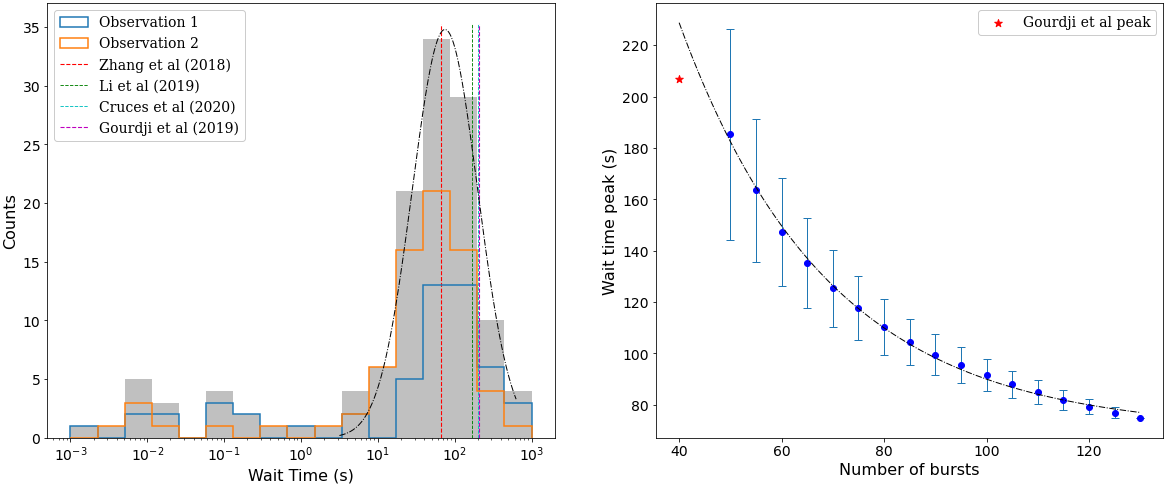

<Figure size 511.2x315.939 with 0 Axes>

<IPython.core.display.Javascript object>

In [11]:
# Create final plot
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

with plt.style.context(["science", "grid", "no-latex"]):
    plt.figure(
        figsize=set_size(width="full")
    )  # for half page width figures use full for full page width figures
    # ax[0].plot(bin_centers, ln_data, 'ro')  #Plots data used to make histogram
    ax[0].plot(xaxis, yfit, "k-.")
    ax[0].set_xscale("log")
    ax[0].hist(all_diffs, bins=bins, color="silver")
    # ax[0].vlines(x=xaxis[max_index], ymin=0, ymax=max_hist+2, linestyles='dashed') #Plots vertical line at fitted WT peak
    ax[0].set_xlabel("Wait Time (s)", fontsize=16)
    ax[0].set_ylabel("Counts", fontsize=16)

    # Plot each individual observation wait time distribution on top
    for i in range(0, len(sep_pulse_times)):
        these_diffs = []
        these_pts = sep_pulse_times[i]  # array of pulse times from just one MJD
        for j in range(0, len(these_pts) - 1):
            diff = (
                these_pts[j + 1] - these_pts[j]
            ) * 86400.0  # again assuming pulse times are in MJD
            if diff < max_diff:
                these_diffs.append(diff)
        # After getting all WTs for one observation, plot
        ax[0].hist(
            these_diffs,
            bins=bins,
            histtype="step",
            linewidth=1.5,
            label="Observation " + str(i + 1),
        )

    # Plot peaks from other papers
    ymax = max_hist + 0.5
    ax[0].vlines(
        x=67,
        ymin=0,
        ymax=ymax,
        colors="r",
        linestyles="dashed",
        linewidth=1.1,
        label="Zhang et al (2018)",
    )  # estimated by Gourdji et al 2019
    ax[0].vlines(
        x=170,
        ymin=0,
        ymax=ymax,
        colors="g",
        linestyles="dashed",
        linewidth=0.9,
        label="Li et al (2019)",
    )  # Li et al 2019
    ax[0].vlines(
        x=200,
        ymin=0,
        ymax=ymax,
        colors="c",
        linestyles="dashed",
        linewidth=0.9,
        label="Cruces et al (2020)",
    )  # Cruces et al 2020
    ax[0].vlines(
        x=207,
        ymin=0,
        ymax=ymax,
        colors="m",
        linestyles="dashed",
        linewidth=1.1,
        label="Gourdji et al (2019)",
    )  # Gourdji et al 2020
    ax[0].legend(fontsize=14)

    ax[1].errorbar(burstnums, all_meanpeaks, yerr=all_stdvs, capsize=4, linestyle="")
    ax[1].plot(burstnums, all_meanpeaks, "bo", linestyle="")
    ax[1].plot(xaxis_rand, yfit_rand, "k-.")
    ax[1].scatter(40, 207, s=64, color="r", marker="*", label="Gourdji et al peak")
    ax[1].legend(fontsize=14)

    # Tick font sizes
    fsize = 14
    for tick in ax[0].xaxis.get_major_ticks():
        tick.label.set_fontsize(fsize)
    for tick in ax[0].yaxis.get_major_ticks():
        tick.label.set_fontsize(fsize)
    for tick in ax[1].xaxis.get_major_ticks():
        tick.label.set_fontsize(fsize)
    for tick in ax[1].yaxis.get_major_ticks():
        tick.label.set_fontsize(fsize)
    ax[1].set_xlabel("Number of bursts", fontsize=16)
    ax[1].set_ylabel("Wait time peak (s)", fontsize=16)
    # plt.savefig("wt_final.png")
    # plt.savefig("wt_final.pdf", bbox_inches="tight")

    plt.show()

Below, a scatter plot is made between the relative wait time between bursts and their fluence ratio.

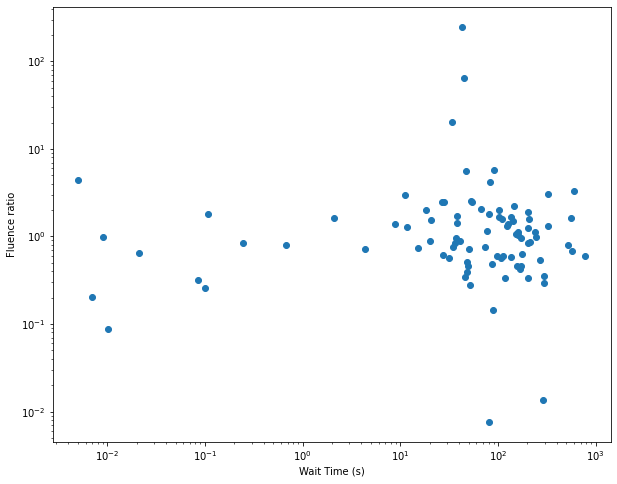

<IPython.core.display.Javascript object>

In [12]:
mjd_flu = np.array(
    datadict_flu["MJD"]
)  # only using bursts for which we have good fluence measurements
fluences = np.array(datadict_flu["fluence"])
diffs = []
fluence_ratios = []
for i in range(0, len(mjd_flu) - 1):
    diff = (mjd_flu[i + 1] - mjd_flu[i]) * 86400
    if diff < max_diff and diff > 0.005:
        diffs.append(diff)
        fluence_ratio = fluences[i + 1] / fluences[i]
        fluence_ratios.append(fluence_ratio)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlabel("Wait Time (s)")
ax.set_ylabel("Fluence ratio")
plt.xscale("log")
plt.yscale("log")
ax.scatter(diffs, fluence_ratios)

Finally, we only look at the bursts for which we were able to get a good fluence fit, and see how the wait time peak changes when the lowest fluence bursts are removed. <br>
This allows us to compare our result with the wait time peak vs. removal of random bursts.

In [13]:
burstnums_le = np.linspace(len(bursts_by_fluence) - 40, len(bursts_by_fluence), num=9)
print(burstnums_le)

[54. 59. 64. 69. 74. 79. 84. 89. 94.]


<IPython.core.display.Javascript object>

In [14]:
# REMOVING LOWEST ENERGY BURSTS
all_LE_wt_peaks = []
all_LE_peak_errors = []
all_min_fluences = []

for num in burstnums_le:
    num = int(num)
    highest_n_bursts = bursts_by_fluence.tail(num)
    min_fluence = highest_n_bursts.iloc[0][1]
    all_min_fluences.append(min_fluence)
    burst_times = highest_n_bursts.loc[:, "MJD"]
    burst_times = np.sort(burst_times)

    (
        bin_centers,
        ln_data,
        xaxis,
        yfit,
        diffs,
        bins,
        perr,
    ) = hist_fit(burst_times, num_bins, min_diff, max_diff)
    max_hist = np.amax(yfit)
    max_index = np.where(yfit == max_hist)
    wt_peak = np.round(xaxis[max_index], 2)
    all_LE_wt_peaks.append(wt_peak)
    peak_error = np.round(perr[1], 2)
    all_LE_peak_errors.append(peak_error)

    print(
        str(len(burst_times))
        + " bursts, peak at "
        + str(wt_peak[0])
        + " +/- "
        + str(peak_error)
        + " s"
    )

54 bursts, peak at 253.41 +/- 0.78 s
59 bursts, peak at 209.75 +/- 0.38 s
64 bursts, peak at 196.93 +/- 0.22 s
69 bursts, peak at 187.04 +/- 0.22 s
74 bursts, peak at 155.19 +/- 0.23 s
79 bursts, peak at 144.57 +/- 0.29 s
84 bursts, peak at 122.85 +/- 0.27 s
89 bursts, peak at 112.3 +/- 0.23 s
94 bursts, peak at 103.81 +/- 0.14 s


<IPython.core.display.Javascript object>

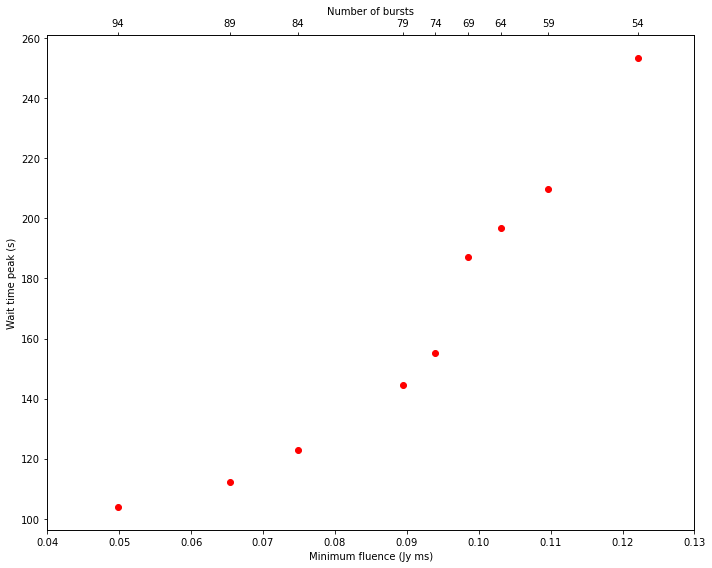

<IPython.core.display.Javascript object>

In [15]:
fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.plot(all_min_fluences, all_LE_wt_peaks, "ro", linestyle="")
ax1.set_xlim(0.04, 0.13)
ax1.set_xlabel("Minimum fluence (Jy ms)")
ax1.set_ylabel("Wait time peak (s)")

ax2 = ax1.twiny()
ax2.set_xlabel("Number of bursts")
ax2.set_xlim(0.04, 0.13)
ax2.set_xticks(all_min_fluences)

xticks = [None] * len(burstnums_le)
i = 0
for num in burstnums_le:
    num = str(int(num))
    xticks[i] = num
    i += 1

ax2.set_xticklabels(xticks)
fig.tight_layout()

plt.show()